---
### **<p style="text-align: center; text-decoration: underline;">Introduction to GCNs</p>**
# **<p style="text-align: center;">Graph Convolutional Networks (GCNs) for Sign Language Alphabets Recognition</p>**
---

> Realized by: *Omar Ikne*.

> Master 1 & 2, IMT Nord Europe.

---

### ■ __Overview__
In this notebook, we will investigate the utilization of Graph Convolutional Networks (GCNs) for static hand gesture recognition. Specifically, we aim to recognize sign language alphabets using graph representations. The fundamental concept involves using the capabilities of GCNs to extract insightful features from hand joints and subsequently classify each gesture individually.

The main task of this lab is to build a graph-based deep learning model to recognize the Sign Language Alphabets (figure bellow).
#### **Main Task: Sign Language Alphabets Recognition**
![Alt text](https://github.com/SegwayWarrior/Gesture_Recognition_opencv_yolov5/blob/master/sign_lang_detection/asl-alphabet_wallpaper_1920x1200.png?raw=true "sign language alphabet")

### ■ **<a name="content">Contents</a>**

- [1. Preliminaries](#section1)

- [1. Sign Language Alphabets Dataset](#section2)

- [2. GCN Model](#section3)

- [3. Model Training](#section4)

- [4. Model Evaluation](#section5)

- [5. Demo](#section6)

In [ ]:
## download the dataset
#!pip uninstall gdown -y && pip install gdown
!gdown https://drive.google.com/u/1/uc?id=11Dr8n-bcBUgAh_C5mNOkMT5nLcKxw4zN&export=download

Downloading...
From: https://drive.google.com/u/1/uc?id=11Dr8n-bcBUgAh_C5mNOkMT5nLcKxw4zN
To: /content/sign_lang_ds.zip
100% 370M/370M [00:03<00:00, 93.7MB/s]


In [ ]:
## unzip the dataset
!unzip /content/sign_lang_ds.zip

Streaming output truncated to the last 5000 lines.
  inflating: sign_lang_ds/labels/train/k_222.txt  
  inflating: sign_lang_ds/labels/train/k_223.txt  
  inflating: sign_lang_ds/labels/train/k_224.txt  
  inflating: sign_lang_ds/labels/train/k_226.txt  
  inflating: sign_lang_ds/labels/train/k_227.txt  
 extracting: sign_lang_ds/labels/train/k_229.txt  
  inflating: sign_lang_ds/labels/train/k_23.txt  
 extracting: sign_lang_ds/labels/train/k_230.txt  
  inflating: sign_lang_ds/labels/train/k_231.txt  
  inflating: sign_lang_ds/labels/train/k_232.txt  
  inflating: sign_lang_ds/labels/train/k_235.txt  
  inflating: sign_lang_ds/labels/train/k_236.txt  
  inflating: sign_lang_ds/labels/train/k_239.txt  
  inflating: sign_lang_ds/labels/train/k_24.txt  
  inflating: sign_lang_ds/labels/train/k_240.txt  
  inflating: sign_lang_ds/labels/train/k_243.txt  
  inflating: sign_lang_ds/labels/train/k_244.txt  
  inflating: sign_lang_ds/labels/train/k_245.txt  
  inflating: sign_lang_ds/labels/


### ■ **Libraries**

In [ ]:
!pip install torch
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 38.2 MB/s eta 0:00:00


In [ ]:
## torch dependencies
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.parameter import Parameter

## basic dependencies from math and visualization
import numpy as np
import cv2
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math

## mediapipe dependencies
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

### ■ **<a name="pre">1. Preliminaries</a>** [(&#8593;)](#content)
The first section of this notebook is dedicated to equipping you with the necessary tools for extracting hand poses from given hand images.
To achieve this, we will employ the [Mediapipe](https://developers.google.com/mediapipe) framework , which excels in extracting 3D coordinates of 21 hand joints, as illustrated in the figure below.
![Alt text](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmediapipe.dev%2Fimages%2Fmobile%2Fhand_landmarks.png&f=1&nofb=1&ipt=6419045b640e8d4171e57052c8e7984fb4cc20a3274dfd7bdfafe60913346f61&ipo=images "Media pipe hand pose")

In [ ]:
## create the mediapipe hand tool to extract hand joints.
mpHands = mp.solutions.hands
hands = mpHands.Hands(max_num_hands=2, min_detection_confidence=0.3, min_tracking_confidence=0.5)

def get_hand_landmarks(image):
    """
    returns the hand landmarks given the image: shape [n_hands, n_joints, n_coords]
    n_hands: 1/2 number of hands
    n_joints: 21 joints
    n_coords: (x, y, z) coordinates
    """
    ## create an image copy
    originalImage = image.copy()
    # mediapipe requires RGB image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ## porcess image
    results = hands.process(image)
    ## returns None if hand is not found
    landMarkList = []
    if results.multi_hand_landmarks:
        for idx in range(len(results.multi_hand_landmarks)):
            ## results.multi_hand_landmarks returns landMarks for all the hands
            hand = results.multi_hand_landmarks[idx]
            landMarkList.append([[landMark.x, landMark.y, landMark.z] for landMark in hand.landmark])
    return landMarkList

def draw_landmarks_on_image(rgb_image, hand_landmarks_list):
    annotated_image = np.copy(rgb_image)
    # Loop through the detected hands to visualize.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
              landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for (x, y, z) in hand_landmarks
            ])
        solutions.drawing_utils.draw_landmarks(
          annotated_image,
          hand_landmarks_proto,
          solutions.hands.HAND_CONNECTIONS,
          solutions.drawing_styles.get_default_hand_landmarks_style(),
          solutions.drawing_styles.get_default_hand_connections_style())
    return annotated_image


def hand_pose_detection_demo(image_file):
    image = cv2.imread(image_file)
    landmarks = get_hand_landmarks(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    annotated_image = draw_landmarks_on_image(image, landmarks)
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.show()

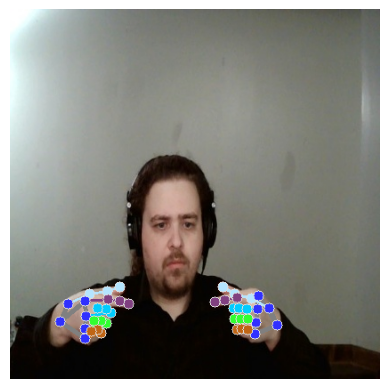

In [ ]:
## show an example
file = './sign_lang_ds/images/train/g_209.jpg'
hand_pose_detection_demo(file)

### ■ **<a name="dataset">2. Dataset</a>** [(&#8593;)](#content)
In this second section, our focus shifts to creating the dataset essential for training the Graph Convolutional Network (GCN). The dataset is designed to provide hand poses, the corresponding adjacency matrices, and the associated sign labels.
The original image dataset can be downloaded from this [link](https://drive.google.com/file/d/11Dr8n-bcBUgAh_C5mNOkMT5nLcKxw4zN/view).

#### **2.1. Hand Adjacency Matrix**
We begin the process by creating our hand adjacency matrix. To achieve this, we adhere to the skeletal structure outlined by Mediapipe, as shonw in the figure below.

![Alt text](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmediapipe.dev%2Fimages%2Fmobile%2Fhand_landmarks.png&f=1&nofb=1&ipt=6419045b640e8d4171e57052c8e7984fb4cc20a3274dfd7bdfafe60913346f61&ipo=images "Media pipe hand pose")

<Axes: >

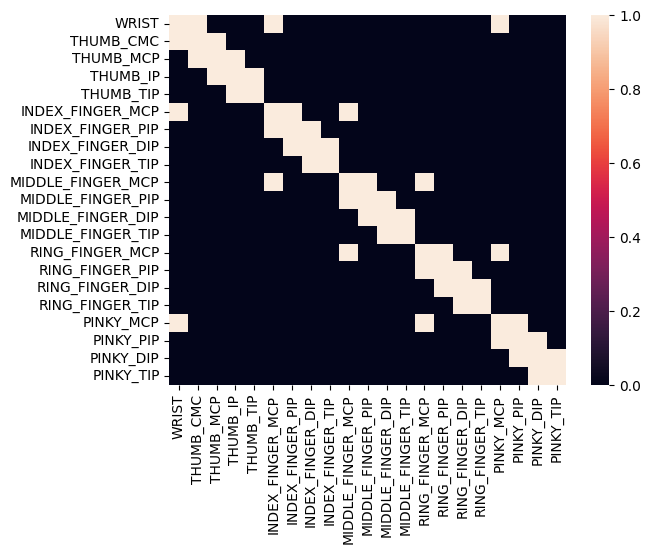

In [ ]:
def get_hand_adjacency_matrix():
    """returns the hand adjacency matrix for mediapipe extracted pose."""
    n_joints = len(solutions.hands.HAND_CONNECTIONS)
    A = np.zeros((n_joints, n_joints))
    for i, j in solutions.hands.HAND_CONNECTIONS:
        A[i][j] = 1.
        A[j][i] = 1.
    ## add self-loops
    A += np.eye(A.shape[0])
    return A

## create the hand adjacency matrix
hand_adjacency_matrix = get_hand_adjacency_matrix()

## display the adj matrix
names = [solutions.hands.HandLandmark(i).name for i in range(21)]
sns.heatmap(hand_adjacency_matrix, xticklabels=names, yticklabels=names)
plt.show()

#### **2.2 Define the dataset**

In [ ]:
## store alphabets in an array
alphabets = ['A',
             'B',
             'C',
             'D',
             'E',
             'F',
             'G',
             'H',
             'I',
             'J',
             'K',
             'L',
             'M',
             'N',
             'O',
             'P',
             'Q',
             'R',
             'S',
             'T',
             'U',
             'V',
             'W',
             'X',
             'Y',
             'Z']

len(alphabets)

26

In [ ]:
class HandPoseDataset(Dataset):
    """Hand Pose Dataset.
    Input:
        data_dir: the directory where the images are stored.
        img_ext: the extension of the images in ['*.png', ''*.jpg', '.*jpeg']

    The dataset yeilds an output with three components:
        hand_pose: shape (21, 3) corresponding to number of joints x number of coodinates
        adjacency matrix: shape (21, 21) encoding the adjacency between the different joints
        label: the corresponding sign alphabet
    """
    def __init__(self,
                 data_dir,
                 img_ext='*.jpg'):

        ## data
        self.data_dir = data_dir
        self.img_ext = img_ext

        ## to convert alphabets to indices 'A - > 0', 'B -> 1', ..., 'Z -> 25'
        self.alphabet_to_label = dict(zip(alphabets, range(len(alphabets))))
        ## to convert indices into alphabets '0 -> A', '1 -> B', ..., '25 -> Z'
        self.label_to_alphabet = {idx:label for label, idx in self.alphabet_to_label.items()}

        ## load the data by extracting the hand poses from images
        self.data = self.get_data()

    def get_data(self):
        """loads the hand pose data by extarcting the coordinates of the joints from RGB images"""

        ## initiate an array to store the data into
        data = []

        ## get all the images in the data directory with the given extension
        files = glob.glob(os.path.join(self.data_dir, self.img_ext))

        ## get the adjacency matrix
        adjacency_matrix = get_hand_adjacency_matrix()

        ## for each image
        for file in tqdm(files, desc='extracting hand poses from images....'):
            ## read the image
            image = cv2.imread(file)
            ## get the alphabet corresponding to the label, the image file is encoded as 'alphabet_x.png'
            alphabet = file.split('/')[-1].split('_')[0].upper()
            ## extract landmarks using mediapipe
            landmarks = get_hand_landmarks(image)

            ## for each hand (right & left)
            for hand_pose in landmarks:
                ## check is mediapipe succefully extracted the hand landmarks
                if len(hand_pose) > 0:
                    hand_pose = np.array(hand_pose)
                    data.append((hand_pose, adjacency_matrix, alphabet))

        print(f"From {len(files)}, succefully extracted {len(data)} hand poses !")
        return data

    def __len__(self):
        """returns the number of elements in the dataset"""
        return len(self.data)

    def __getitem__(self, index):

        ## get files paths
        hand_pose, adjacency_matrix, alphabet = self.data[index]
        label = self.alphabet_to_label[alphabet]

        ## covert data to tensors
        hand_pose = torch.from_numpy(hand_pose).type(torch.float32)
        adjacency_matrix = torch.from_numpy(adjacency_matrix).type(torch.float32)
        label = torch.tensor(label).type(torch.long)

        return dict(Hand_pose=hand_pose,
                    Adjacency_matrix=adjacency_matrix,
                    Label=label)

In [ ]:
## train & test data directories
train_dir = "./sign_lang_ds/images/train/"
test_dir = "./sign_lang_ds/images/test/"

## create train and test sets
train_set = HandPoseDataset(train_dir)
test_set  = HandPoseDataset(test_dir)

extracting hand poses from images....: 100%|██████████| 8288/8288 [12:01<00:00, 11.49it/s]


From 8288, succefully extracted 10668 hand poses !


extracting hand poses from images....: 100%|██████████| 2072/2072 [02:55<00:00, 11.79it/s]

From 2072, succefully extracted 2640 hand poses !


Here we do some data analysis by ploting the number of samples per class. This allows us to see whether the data is balanced or not !

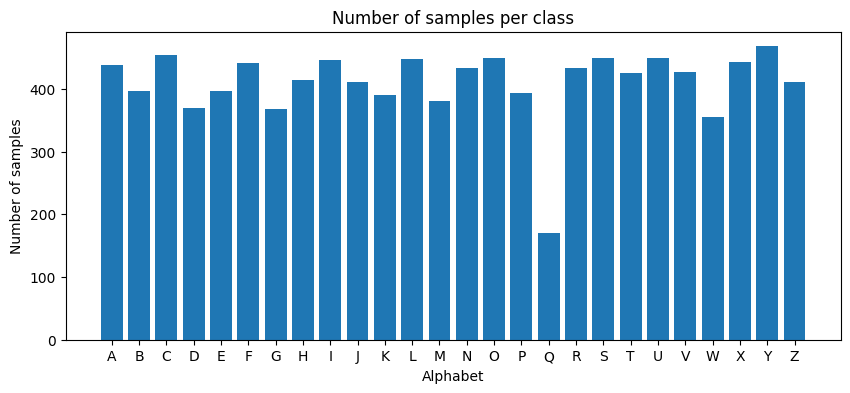

In [ ]:
## plot the number of samples per class
train_labels = [y for _, _, y in train_set.data]

values, counts = np.unique(train_labels, return_counts=True)

plt.figure(figsize=(10, 4))
plt.bar(values, counts)
plt.title('Number of samples per class')
plt.xlabel('Alphabet')
plt.ylabel('Number of samples')
plt.show()

#### **Create data loader**
In pytorch, dataloader are an essential component to train deep learning models.

In [ ]:
## define a batch size
batch_size = 64

## define the training and test data loader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## stats
print('The number of training batches:', len(train_loader))
print('The number of testing batches :', len(test_loader))

The number of training batches: 167
The number of testing batches : 42


In [ ]:
## check that the loaders work well by extracting an element from the laoder.
## out is a dictionary that contains a batch data from the loader.
## out contains: Hand_pose -> shape(batch_size, 21, 3), Adjacency_matrix -> shape (batch_size, 21, 21), Label -> shape (batch_size)
out = next(iter(train_loader))
out['Hand_pose'].shape, out['Adjacency_matrix'].shape, out['Label'].shape

(torch.Size([64, 21, 3]), torch.Size([64, 21, 21]), torch.Size([64]))

### ■ **<a name="model">3. GCN Model</a>** [(&#8593;)](#content)
No that the dataloaders are ready, we can build our GCN model to classify sign alphabets ! We start by defining the Graph Convolution Layer.

#### **3.1. Graph Convolution Layer**
The updating rule for the graph convolution layers is given by:
$$
H^{(l+1)} = \sigma\left(AH^{(l)}W^{(l)} + b ^{(l)}\right)
$$
Where:
- $\sigma$ is the activation function.
- $A$ is the adjacency matrix,
- $H^{(l)}$ is the node features at layer $l$.
- $W^{(l)}$ are the learned weights of the $l$-th layer.
- $b^{(l)}$ is the bias of the $l$-th layer.

In [ ]:
class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        ## X.H
        support = torch.bmm(input, self.weight.unsqueeze(0).repeat(input.shape[0], 1, 1))
        ## A.H.W
        output = torch.bmm(adj, support)
        if self.bias is not None:
            ## A.H.W + b
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

#### **GCN module**
Now we defie the GCN model by stacking a set of GCN layers to extract features, and an MLP layer to classify the extracted features into different classes.

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_dim, n_nodes, hidden_dim, n_gcn_layers, n_classes, dropout):
        super(GCN, self).__init__()

        ## GCN layers to learn graph representation
        self.gc1 = GraphConvolution(in_dim, hidden_dim)
        self.gc2 = GraphConvolution(hidden_dim, hidden_dim)

        ## MLP head to classify the graphs
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * n_nodes, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

        ## dropout parameter to prevent overfitting
        self.dropout = dropout

    def forward(self, x, adj):

        ## first gcn layer with activation function and dropout
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)

        ## second gcn layer
        x = self.gc2(x, adj)

        ## reshape x from (b, n_joints, hidden_dim) into (b, n_joints * hidden_dim)
        b, _, _ = x.shape
        x = x.view(b, -1)

        ## mlp for classification
        out = self.mlp(x)

        return out

### ■ **<a name="train">4. Model Training</a>** [(&#8593;)](#content)
We are now ready to train our model. We define a `train_epoch` function to train our model for one epoch.

In [ ]:
def train_epoch(epoch, num_epochs, model, optimizer, dataloader, device, criterion, scheduler=None):
    """
    to train the model for one epoch !
    Params:
    ======
        - epoch: current epoch,
        - num_epochs: total number of epochs,
        - model: model to train,
        - optimizer: optimizer to optimize the loss of the model,
        - dataloader: the training data laoder.
        - device: cpu or gpu,
        - criterion: the loss function: crossentropy,
        - sheduler: if any to adjust the learning rate of the optimizer.
    """

    ## make the model in train mode
    model.train()

    ## create a progression bar to display the progression of training
    pbar = tqdm(dataloader, total=len(dataloader))
    total_loss = 0

    ## for each batch
    for d in pbar:
        ## get data from the batch
        hand_pose = d['Hand_pose'].to(device)
        adj_matrix = d['Adjacency_matrix'].to(device)
        label = d['Label'].to(device)

        ## predict and calculate the loss on the given batch, and optimize the loss accordingly
        optimizer.zero_grad()
        pred = model(hand_pose, adj_matrix)
        loss_train = criterion(pred, label)
        loss_train.backward()
        optimizer.step()

        total_loss += loss_train.item()
        ## set the discription bar
        pbar.set_description(f'[%.2g/%.2g] train loss. %.2f' % (epoch, num_epochs, total_loss/len(hand_pose)))

    if scheduler is not None:
        scheduler.step()

    return total_loss


def validate_epoch(model, dataloader, criterion):
    """to evaluate the model !
    Params:
    ======
        - model: model to evaluate,
        - dataloader: the testing data laoder.
        - criterion: the loss function to calculate the validation loss,
    """

    acc = 0.0
    n = 0
    pred_labels, true_labels = [], []
    total_loss = 0.0

    ## turn the model into evaluation mode
    model.eval()

    ## no need to compute grads in validation stage, this makes the process run fast
    with torch.no_grad():
        pbar = tqdm(dataloader, total=len(dataloader))

        for d in pbar:
            hand_pose = d['Hand_pose'].to(device)
            adj_matrix = d['Adjacency_matrix'].to(device)
            label = d['Label'].to(device)

            pred = model(hand_pose, adj_matrix)
            loss = criterion(pred, label)

            ## calculate accuracy
            acc += (pred.argmax(dim=1) == label.flatten()).sum().item()
            n += len(label.flatten())

            total_loss += loss.item()

            true_labels.extend(label.tolist())
            pred_labels.extend(pred.argmax(dim=1).tolist())

            desc = '[VALID]> loss. %.2f > acc. %.2g%%' % (total_loss/len(hand_pose), (acc / n)*100)
            pbar.set_description(desc)

    accuracy = acc / n

    return total_loss, accuracy, true_labels, pred_labels

In [ ]:
## model parameters
in_dim = 3
hidden_dim = 64
n_gcn_layers = 2
n_classes = 26
dropout = 0.1
n_joints = 21

## device: cpu / gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('available device:', device)

## build model
model = GCN(in_dim=in_dim,
            n_nodes=n_joints,
            hidden_dim=hidden_dim,
            n_gcn_layers=n_gcn_layers,
            n_classes=n_classes,
            dropout=dropout)


## trainig parameters
lr = 1e-3
weight_decay = 5e-2
num_epochs = 15

## create optimizer, schedular and loss function
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0, last_epoch=-1, verbose=False)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

## put model into device
model = nn.DataParallel(model).to(device)

# Training loop
valid_accuracies = []
valid_losses = []
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch(epoch, num_epochs, model, optimizer, train_loader, device, criterion)
    valid_loss, val_acc, true_labels, pred_labels = validate_epoch(model, test_loader, criterion)

    valid_accuracies.append(val_acc * 100)
    valid_losses.append(valid_loss)

available device: cpu


[VALID]> loss. 2.65 > acc. 93%: 100%|██████████| 42/42 [00:00<00:00, 88.15it/s]


### ■ **<a name="eval">4. Model Evaluation</a>** [(&#8593;)](#content)
Now we evaluate our trained model. We plot both the validation loss and accuracy. We also plot the confusion matrix for different classes.

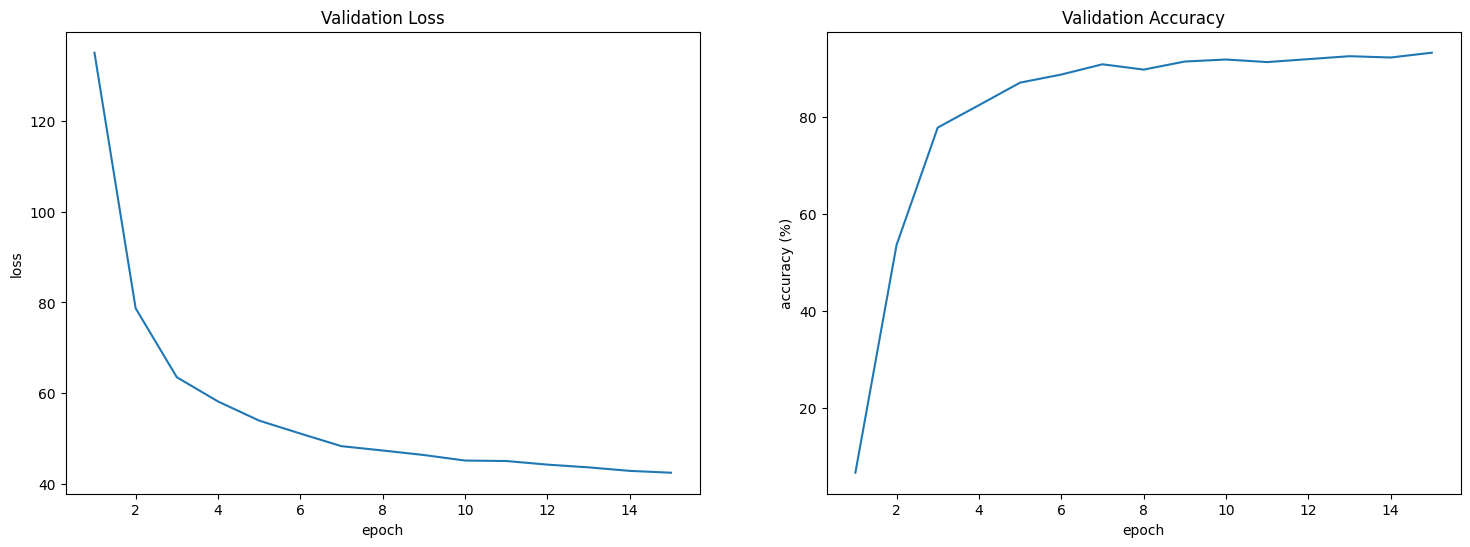

The best validation accuracy: 93.26%


In [ ]:
## display validation loss and accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

## loss
ax1.plot(range(1, num_epochs+1), valid_losses)
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_title('Validation Loss')

## accuracy
ax2.plot(range(1, num_epochs+1), valid_accuracies)
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy (%)')
ax2.set_title('Validation Accuracy')

plt.show()

print(f'The best validation accuracy: {round(np.max(valid_accuracies), 2)}%')

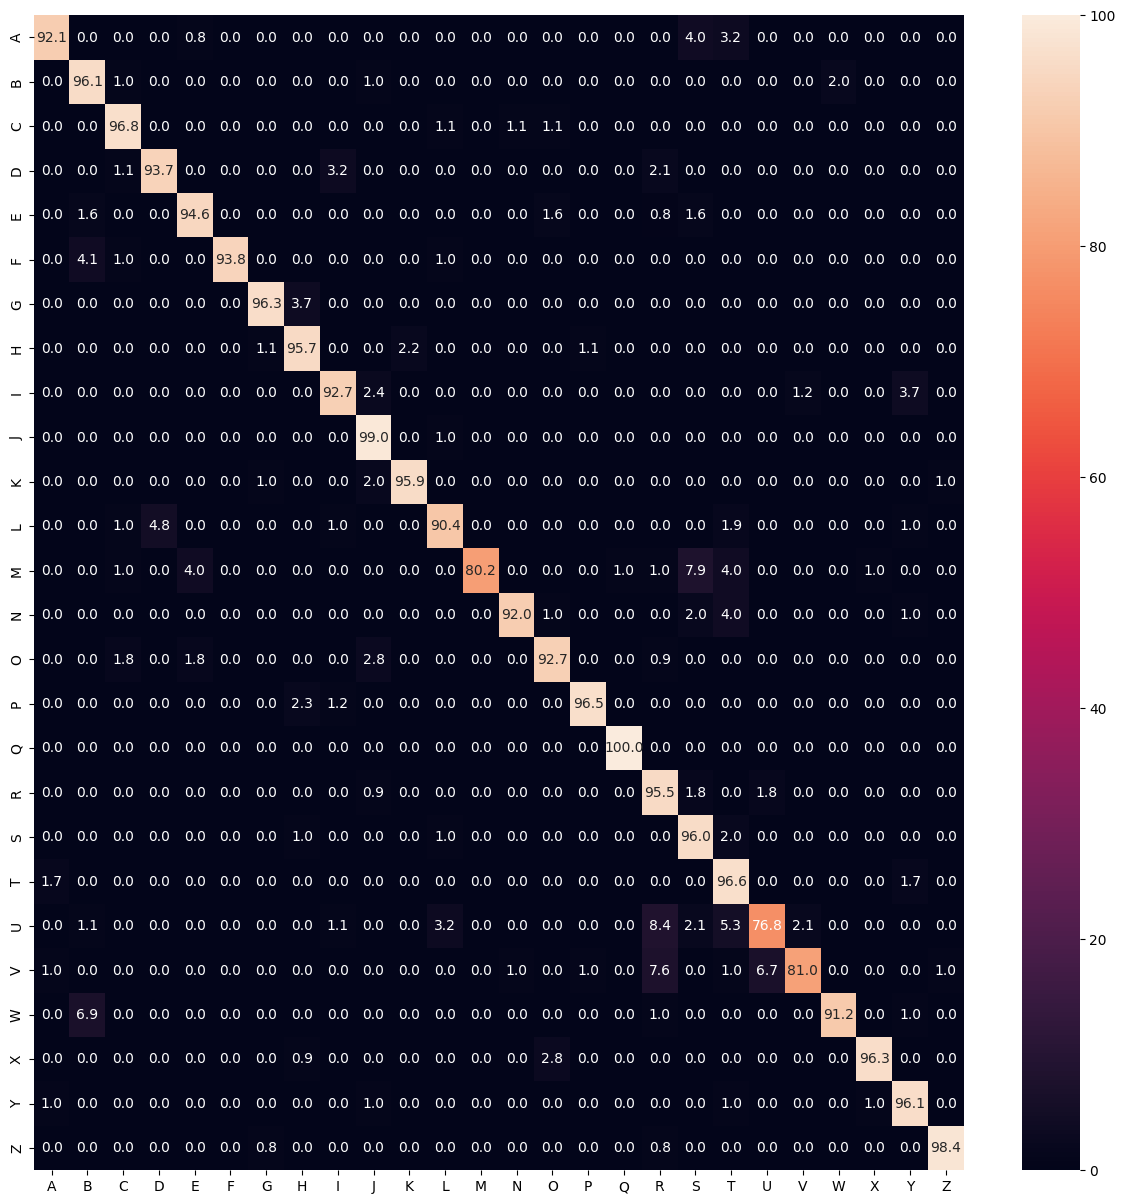

In [ ]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(confusion_matrix(true_labels, pred_labels, normalize='true')*100, ax=ax, annot=True, fmt='.1f', xticklabels=alphabets, yticklabels=alphabets)
plt.show()

### ■ **<a name="demo">4. Demo</a>** [(&#8593;)](#content)
You now test the model on any given  image. You can also try your own image. An interesting perspective is to build a real time Alphabet recognition to communicate with the computer !

In [ ]:
def plot_prediction_confidence(probas):
    """plots the prediction confidence across classes !"""
    fig, ax = plt.subplots(figsize=(15, 4))
    x = np.arange(len(alphabets))
    left_hand_p  = probas[0]
    right_hand_p = probas[1]

    ax.bar(x-0.3, left_hand_p, width=0.3, color='b', align='center', alpha=0.8, label='Left hand')
    ax.bar(x, right_hand_p, width=0.3, color='r', align='center', alpha=0.8, label='Right hand')
    ax.set_xticks(x)
    ax.set_xticklabels(alphabets)
    ax.set_xlabel('Alphabet')
    ax.set_ylabel('Confidence')
    ax.set_title('Prediction Confidence')
    plt.legend()
    plt.show()

def sign_laphabet_recognition_demo(image_path, model):
    """Predicts the alphabet sign given an image path, and a trained model !"""

    ## check if the image path exists
    if not os.path.exists(image_path):
        raise FileNotFoundError("image path does not exit !")

    ## plot hand pose
    hand_pose_detection_demo(image_path)

    ## put model in mode evaluation
    model.eval()

    ## read the image and extract the landamrks
    image = cv2.imread(image_path)
    true_alphabet = image_path.split('/')[-1].split('_')[0].upper()
    hand_poses = get_hand_landmarks(image)

    if len(hand_poses) == 0:
        hands = []
        print('No hand detected !')
    elif len(hand_poses) == 1:
        hands = ['Left']
        print('Only one hand has been detected !')
    else:
        hands = ['Left', 'Right']

    ## numpy to tensors
    adj_matrix = get_hand_adjacency_matrix()
    hand_poses = np.array(hand_poses)
    hand_poses = torch.from_numpy(hand_poses).type(torch.float32)

    ## add a batch axis
    if len(hand_poses.shape) == 2:
        hand_poses = hand_poses.unsqueeze(0)

    ## to tensors, and add batch index
    adj_matrix = torch.from_numpy(adj_matrix).type(torch.float32)
    adj_matrix = adj_matrix.unsqueeze(0).repeat(hand_poses.shape[0], 1, 1)

    ## predict
    pred = model(hand_poses, adj_matrix)
    probas = F.softmax(pred, dim=1)
    pred_labels = probas.argmax(dim=1)
    ## display
    for e, hand in enumerate(hands):
        pred_alphabet = train_set.label_to_alphabet[pred_labels[e].item()]
        print(hand + ' hand:')
        print('\t> True alphabet     :', true_alphabet)
        print('\t> Predicted alphabet:', pred_alphabet, '| Confidence:', round(probas[e].max().item(), 2))

    ## plot prediction confidence
    plot_prediction_confidence(probas.detach().numpy())

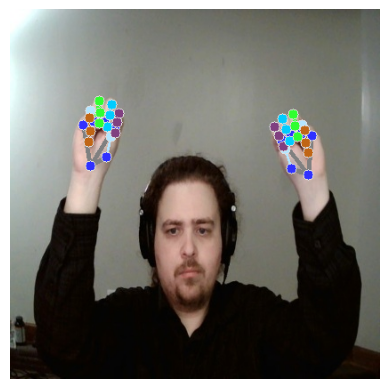

Left hand:
	> True alphabet     : M
	> Predicted alphabet: M | Confidence: 0.84
Right hand:
	> True alphabet     : M
	> Predicted alphabet: M | Confidence: 0.74


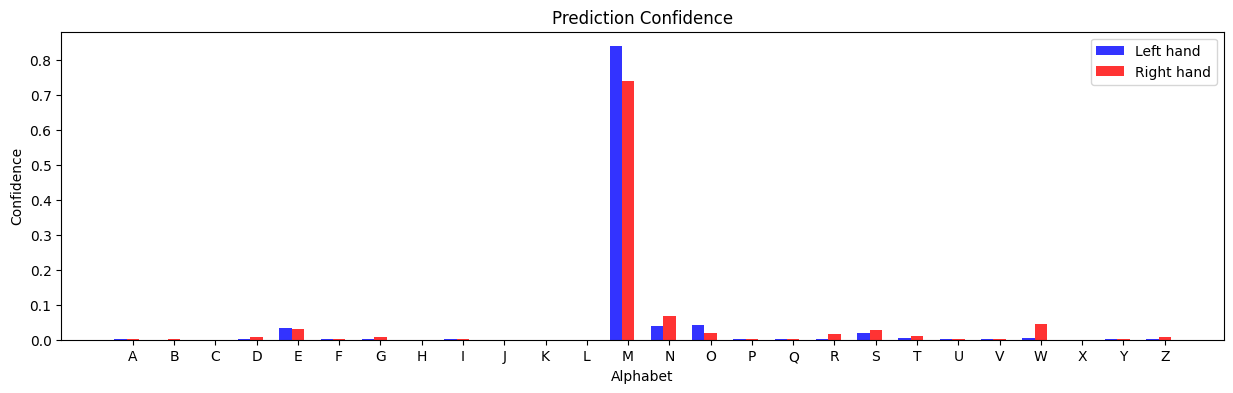

In [ ]:
## provide an image path
image_path = "./sign_lang_ds/images/train/m_136.jpg"

## get the prediction
p = sign_laphabet_recognition_demo(image_path, model)

---
<p style="text-align: center;">Copyright © 2023 Omar Ikne</p>